In [1]:
!pip install pingouin

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.9/198.9 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.5/53.5 kB 3.9 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 21.3
    Uninstalling packaging-21.3:
      Successfully uninstalled packaging-21.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
keras-cv 0.8.2 requires keras-core, which is not installed.
keras-nlp 0.9.3 requires keras-core, which is not installed.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
google-cloud-bigquery 2.34.4 requires packaging<22.0dev,>=14.3, but you have packaging 24.0 which is incompatible.
jupyterlab 4.1.6 requires jupyter-lsp>=2.0.0, but you have jupyter-lsp 1.5.1 which is incompatible.
jupyterlab-lsp 5.1.0 requires jupyter-lsp>=2.0.0, but you have jupyter-lsp 1.5.1 which is in

In [2]:
!pip install yellowbrick

# Importação das Bibliotecas

In [3]:
import math
import pandas as pd
import numpy as np
import pingouin as pg
import sklearn
from scipy.stats import norm
from scipy.stats import chi2_contingency
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# Importação do banco de dados

In [4]:
db_smoke_detection = pd.read_csv("/kaggle/input/smoke-detection-dataset/smoke_detection_iot.csv")

In [5]:
db_smoke_detection.head()

,Unnamed: 0,UTC,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],PM1.0,PM2.5,NC0.5,NC1.0,NC2.5,CNT,Fire Alarm
0,0,1654733331,20.000,57.36,0,400,12306,18520,939.735,0.0,0.0,0.0,0.0,0.0,0,0
1,1,1654733332,20.015,56.67,0,400,12345,18651,939.744,0.0,0.0,0.0,0.0,0.0,1,0
2,2,1654733333,20.029,55.96,0,400,12374,18764,939.738,0.0,0.0,0.0,0.0,0.0,2,0
3,3,1654733334,20.044,55.28,0,400,12390,18849,939.736,0.0,0.0,0.0,0.0,0.0,3,0
4,4,1654733335,20.059,54.69,0,400,12403,18921,939.744,0.0,0.0,0.0,0.0,0.0,4,0


# Análise dos atributos

**Atributos Preditivos**
- Unnamed:0: Índice
- UTC: Tempo em Segundos UTC
- Temperature[C]: Tempertatura do Ar
- Humidity[%]: Umidade do Ar
- TVOC[ppb]: Total de Compostos Orgânicos Voláteis (medido em partes por bilhão)
- eCO2[ppm]: Concentração equivalente de CO2 (medido em partes por milhão)
- Raw H2: Hidrogênio molecular bruto, não compensado (viés, temperatura, etc.)
- Raw Ethanol: Etanol gasoso bruto
- Pressure[hPA]: Pressão do Ar
- PM1.0: Material particulado de tamanho < 1,0 µm (PM1.0).
- PM2.5: Material particulado de tamanho >1,0 µm e < 2,5 µm (PM2.5).
- NC0.5: Concentração numérica de material particulado de tamanho < 0,5 µm (NC0.5)
- NC1.0: Concentrção numérica de material particulado de tamanho 0,5 µm < 1,0 µm (NC1.0)
- NC2.5: Concentração numérica de material particulado de tamanho 1,0 µm < 2,5 µm (NC2.5)
- CNT: Contador de amostras

**Atributo Alvo**
- Fire Alarm: É 1, se houver incêndio, e 0, caso contrário.

**Informações sobre o banco de dados**

In [6]:
db_smoke_detection.info() # Verificando a quantidade de valores não-nulos e o tipo de cada atributo

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62630 entries, 0 to 62629
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      62630 non-null  int64  
 1   UTC             62630 non-null  int64  
 2   Temperature[C]  62630 non-null  float64
 3   Humidity[%]     62630 non-null  float64
 4   TVOC[ppb]       62630 non-null  int64  
 5   eCO2[ppm]       62630 non-null  int64  
 6   Raw H2          62630 non-null  int64  
 7   Raw Ethanol     62630 non-null  int64  
 8   Pressure[hPa]   62630 non-null  float64
 9   PM1.0           62630 non-null  float64
 10  PM2.5           62630 non-null  float64
 11  NC0.5           62630 non-null  float64
 12  NC1.0           62630 non-null  float64
 13  NC2.5           62630 non-null  float64
 14  CNT             62630 non-null  int64  
 15  Fire Alarm      62630 non-null  int64  
dtypes: float64(8), int64(8)
memory usage: 7.6 MB


In [7]:
db_smoke_detection.isnull().sum() # Verificando se existem valores nulos

Unnamed: 0        0
UTC               0
Temperature[C]    0
Humidity[%]       0
TVOC[ppb]         0
eCO2[ppm]         0
Raw H2            0
Raw Ethanol       0
Pressure[hPa]     0
PM1.0             0
PM2.5             0
NC0.5             0
NC1.0             0
NC2.5             0
CNT               0
Fire Alarm        0
dtype: int64

In [8]:
db_smoke_detection.duplicated().sum() # Analisa a existência de linhas duplicadas

0

**Avaliação da redundância de atributos**

In [9]:
tempo_utc = pd.to_datetime(db_smoke_detection['UTC'], unit='s')
tempo_utc # Criando uma variável para armazenar o tempo convertido de segundos UTC para data e hora.

0       2022-06-09 00:08:51
1       2022-06-09 00:08:52
2       2022-06-09 00:08:53
3       2022-06-09 00:08:54
4       2022-06-09 00:08:55
                ...        
62625   2022-06-13 14:20:47
62626   2022-06-13 14:20:48
62627   2022-06-13 14:20:49
62628   2022-06-13 14:20:50
62629   2022-06-13 14:20:51
Name: UTC, Length: 62630, dtype: datetime64[ns]

In [10]:
tempo_utc.dt.month.value_counts() # Extraindo os meses podemos perceber que todas as amostras foram obtidas no mês 6.

UTC
6    62630
Name: count, dtype: int64

In [11]:
tempo_utc.dt.day.value_counts() # Observando os dias em que foram obtidas as amostras, é possível notar que foram um intervalo próximo, sendo a maioria no dia 9.

UTC
9     49988
8      5744
13     5744
10     1154
Name: count, dtype: int64

In [12]:
tempo_utc.dt.year.value_counts() # Observando que todas as variáveis foram coletadas no mesmo ano.

UTC
2022    62630
Name: count, dtype: int64

In [13]:
len(db_smoke_detection['Unnamed: 0'].unique()) # Analisando a quantidade de valores únicos para o atributo 'Unnamed: 0'.

62630

In [14]:
len(db_smoke_detection['CNT'].unique()) # Analisando a quantidade de valores únicos para o atributo 'CNT'.

24994

# Manipulação do banco de dados

## Excluindo variáveis redudantes

In [15]:
db_smoke_detection = db_smoke_detection.drop(['UTC', 'Unnamed: 0', 'CNT'], axis=1)
db_smoke_detection

,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],PM1.0,PM2.5,NC0.5,NC1.0,NC2.5,Fire Alarm
0,20.000,57.36,0,400,12306,18520,939.735,0.00,0.00,0.00,0.000,0.000,0
1,20.015,56.67,0,400,12345,18651,939.744,0.00,0.00,0.00,0.000,0.000,0
2,20.029,55.96,0,400,12374,18764,939.738,0.00,0.00,0.00,0.000,0.000,0
3,20.044,55.28,0,400,12390,18849,939.736,0.00,0.00,0.00,0.000,0.000,0
4,20.059,54.69,0,400,12403,18921,939.744,0.00,0.00,0.00,0.000,0.000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
62625,18.438,15.79,625,400,13723,20569,936.670,0.63,0.65,4.32,0.673,0.015,0
62626,18.653,15.87,612,400,13731,20588,936.678,0.61,0.63,4.18,0.652,0.015,0
62627,18.867,15.84,627,400,13725,20582,936.687,0.57,0.60,3.95,0.617,0.014,0
62628,19.083,16.04,638,400,13712,20566,936.680,0.57,0.59,3.92,0.611,0.014,0


## Criação de atributos categóricos

**Criando uma variável categorizar a temperatura**

In [16]:
db_smoke_detection['TemperatureCat'] = db_smoke_detection['Temperature[C]'].map(lambda x: 'Muito baixa' if x<0 else ('Baixa' if x<10 else ('Moderada' if x<20 else ('Alta' if x<30 else 'Muito Alta'))))
db_smoke_detection['TemperatureCat']

0            Alta
1            Alta
2            Alta
3            Alta
4            Alta
           ...   
62625    Moderada
62626    Moderada
62627    Moderada
62628    Moderada
62629    Moderada
Name: TemperatureCat, Length: 62630, dtype: object

**Criando uma variável para categorizar a umidade**

In [17]:
db_smoke_detection['HumidityCat'] = db_smoke_detection['Humidity[%]'].map(lambda x: 'Baixa' if x<30 else ('Moderado' if x<60 else 'Alta'))
db_smoke_detection['HumidityCat']

0        Moderado
1        Moderado
2        Moderado
3        Moderado
4        Moderado
           ...   
62625       Baixa
62626       Baixa
62627       Baixa
62628       Baixa
62629       Baixa
Name: HumidityCat, Length: 62630, dtype: object

**Categorizando a ativação do alarme**

In [18]:
db_smoke_detection['SmokeDetec'] = db_smoke_detection['Fire Alarm'].map(lambda x: 'Sim' if x == 1 else 'Não')
db_smoke_detection['SmokeDetec']

0        Não
1        Não
2        Não
3        Não
4        Não
        ... 
62625    Não
62626    Não
62627    Não
62628    Não
62629    Não
Name: SmokeDetec, Length: 62630, dtype: object

## Criação de atributo numéricos

**Criando uma variável para somar a quantidade de material particulado presente no ar**

In [19]:
db_smoke_detection['TotalNC'] = db_smoke_detection['NC0.5']+db_smoke_detection['NC1.0']+db_smoke_detection['NC2.5']
db_smoke_detection['TotalNC']

0        0.000
1        0.000
2        0.000
3        0.000
4        0.000
         ...  
62625    5.008
62626    4.847
62627    4.581
62628    4.545
62629    4.521
Name: TotalNC, Length: 62630, dtype: float64

In [20]:
db_smoke_detection['TotalPM'] = db_smoke_detection['PM1.0']+db_smoke_detection['PM2.5']
db_smoke_detection['TotalPM']

0        0.00
1        0.00
2        0.00
3        0.00
4        0.00
         ... 
62625    1.28
62626    1.24
62627    1.17
62628    1.16
62629    1.16
Name: TotalPM, Length: 62630, dtype: float64

## Análise Estatística

In [21]:
db_quantitativos = ['Temperature[C]', 'Humidity[%]', 'TVOC[ppb]', 'eCO2[ppm]', 'Raw H2', 'Raw Ethanol', 'Pressure[hPa]', 'TotalPM','TotalNC']
db_qualitativos = ['TemperatureCat', 'HumidityCat', 'SmokeDetec']

### Análise de Medidas

- **Descrição Estatística do Banco de Dados**

In [22]:
db_smoke_detection[db_quantitativos].describe()

,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],TotalPM,TotalNC
count,62630.000000,62630.000000,62630.000000,62630.000000,62630.000000,62630.000000,62630.000000,62630.000000,62630.000000
mean,15.970424,48.539499,1942.057528,670.021044,12942.453936,19754.257912,938.627649,285.062079,775.099138
std,14.359576,8.865367,7811.589055,1905.885439,272.464305,609.513156,1.331344,2871.098195,7042.638525
min,-22.010000,10.740000,0.000000,400.000000,10668.000000,15317.000000,930.852000,0.000000,0.000000
25%,10.994250,47.530000,130.000000,400.000000,12830.000000,19435.000000,938.700000,2.630000,10.227000
50%,20.130000,50.150000,981.000000,400.000000,12924.000000,19501.000000,938.816000,3.690000,14.436000
75%,25.409500,53.240000,1189.000000,438.000000,13109.000000,20078.000000,939.418000,4.270000,16.719000
max,59.930000,75.200000,60000.000000,60000.000000,13803.000000,21410.000000,939.861000,59731.400000,104063.534000


- **Médias**

In [23]:
db_smoke_detection[db_quantitativos].mean()

Temperature[C]       15.970424
Humidity[%]          48.539499
TVOC[ppb]          1942.057528
eCO2[ppm]           670.021044
Raw H2            12942.453936
Raw Ethanol       19754.257912
Pressure[hPa]       938.627649
TotalPM             285.062079
TotalNC             775.099138
dtype: float64

- **Moda**

In [24]:
db_smoke_detection[db_quantitativos].mode().iloc[0]

Temperature[C]       24.480
Humidity[%]          47.450
TVOC[ppb]             0.000
eCO2[ppm]           400.000
Raw H2            12969.000
Raw Ethanol       19438.000
Pressure[hPa]       938.709
TotalPM               3.650
TotalNC              14.691
Name: 0, dtype: float64

- **Medianas**

In [25]:
db_smoke_detection[db_quantitativos].median()

Temperature[C]       20.130
Humidity[%]          50.150
TVOC[ppb]           981.000
eCO2[ppm]           400.000
Raw H2            12924.000
Raw Ethanol       19501.000
Pressure[hPa]       938.816
TotalPM               3.690
TotalNC              14.436
dtype: float64

- **Desvio Padrão**

In [26]:
db_smoke_detection[db_quantitativos].std()

Temperature[C]      14.359576
Humidity[%]          8.865367
TVOC[ppb]         7811.589055
eCO2[ppm]         1905.885439
Raw H2             272.464305
Raw Ethanol        609.513156
Pressure[hPa]        1.331344
TotalPM           2871.098195
TotalNC           7042.638525
dtype: float64

- **Variância**

In [27]:
db_smoke_detection[db_quantitativos].var()

Temperature[C]    2.061974e+02
Humidity[%]       7.859473e+01
TVOC[ppb]         6.102092e+07
eCO2[ppm]         3.632399e+06
Raw H2            7.423680e+04
Raw Ethanol       3.715063e+05
Pressure[hPa]     1.772476e+00
TotalPM           8.243205e+06
TotalNC           4.959876e+07
dtype: float64

- **Coeficiente de Variação (Desvio/Média)**

In [28]:
((db_smoke_detection[db_quantitativos].std())/(db_smoke_detection[db_quantitativos].mean()))*100

Temperature[C]      89.913559
Humidity[%]         18.264233
TVOC[ppb]          402.232629
eCO2[ppm]          284.451579
Raw H2               2.105198
Raw Ethanol          3.085477
Pressure[hPa]        0.141839
TotalPM           1007.183488
TotalNC            908.611323
dtype: float64

- **Percentis**

In [29]:
db_smoke_detection[db_quantitativos].quantile([0.15, 0.25, 0.45, 0.75, 0.85])

,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],TotalPM,TotalNC
0.15,-4.27365,45.56,52.0,400.0,12788.0,19406.00,937.449,1.37,5.34400
0.25,10.99425,47.53,130.0,400.0,12830.0,19435.00,938.700,2.63,10.22700
0.45,19.14000,49.46,649.0,400.0,12907.0,19469.00,938.773,3.59,14.02900
0.75,25.40950,53.24,1189.0,438.0,13109.0,20078.00,939.418,4.27,16.71900
0.85,26.78000,54.00,1312.0,552.0,13167.0,20246.65,939.646,4.59,17.99465


- **Frequência e percentual dos atributos qualitativos**

In [30]:
temp_freq = db_smoke_detection['TemperatureCat'].value_counts()
temp_perc = db_smoke_detection['TemperatureCat'].value_counts(normalize=True)*100
tb_temp = pd.DataFrame({'Frequência': temp_freq,
                        'Percentual': temp_perc.map('{:.2f}%'.format)})
tb_temp.iloc[[2,3,1,0,4]] # Ordenando a ordem de apresentação das linhas

,Frequência,Percentual
TemperatureCat,,
Muito baixa,12024,19.20%
Baixa,3277,5.23%
Moderada,15470,24.70%
Alta,29233,46.68%
Muito Alta,2626,4.19%


In [31]:
hum_freq = db_smoke_detection['HumidityCat'].value_counts()
hum_perc = db_smoke_detection['HumidityCat'].value_counts(normalize=True)*100
tb_hum = pd.DataFrame({'Frequência': hum_freq,
                       'Percentual': hum_perc.map('{:.2f}%'.format)})
tb_hum.iloc[[1,0,2]]

,Frequência,Percentual
HumidityCat,,
Baixa,3664,5.85%
Moderado,57898,92.44%
Alta,1068,1.71%


In [32]:
smoke_freq = db_smoke_detection['SmokeDetec'].value_counts()
smoke_perc = db_smoke_detection['SmokeDetec'].value_counts(normalize=True)*100
tb_smoke = pd.DataFrame({'Frequência': smoke_freq,
                         'Percentual': smoke_perc.map('{:.2f}%'.format)})
tb_smoke

,Frequência,Percentual
SmokeDetec,,
Sim,44757,71.46%
Não,17873,28.54%


#### Análise das medidas para cada valor possível do atributo 'SmokeDetec'

- **Descrição Estatística**

In [33]:
db_smoke_detection[db_smoke_detection['Fire Alarm'] == 1][db_quantitativos].describe() # Análise da descrição estatística para o alarme de fogo ativado

,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],TotalPM,TotalNC
count,44757.000000,44757.000000,44757.000000,44757.000000,44757.000000,44757.000000,44757.000000,44757.000000,44757.000000
mean,14.483152,50.779534,882.013071,553.189356,12960.878053,19623.050428,938.837806,114.564248,274.318513
std,13.825585,5.937239,548.606072,1275.260976,167.385665,307.123385,1.309030,2072.245341,4423.518129
min,-22.010000,13.360000,0.000000,400.000000,10939.000000,17809.000000,930.852000,0.310000,1.229000
25%,5.179000,48.390000,332.000000,400.000000,12861.000000,19427.000000,938.731000,3.240000,12.661000
50%,20.020000,51.400000,1103.000000,404.000000,12933.000000,19454.000000,938.878000,3.810000,14.910000
75%,24.730000,53.470000,1208.000000,480.000000,13086.000000,19918.000000,939.290000,4.360000,17.090000
max,41.410000,70.280000,18062.000000,60000.000000,13637.000000,21109.000000,939.771000,59731.400000,104063.534000


In [34]:
db_smoke_detection[db_smoke_detection['Fire Alarm'] == 0][db_quantitativos].describe() # Análise da descrição estatística dos dados para o alarme de fogo desativado

,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],TotalPM,TotalNC
count,17873.000000,17873.000000,17873.000000,17873.000000,17873.000000,17873.000000,17873.000000,17873.000000,17873.000000
mean,19.694803,42.930077,4596.587255,962.587255,12896.316847,20082.823533,938.101383,712.017345,2029.138101
std,14.982932,11.962854,14255.575585,2921.749928,432.441620,956.339624,1.237957,4228.222946,11072.787181
min,-22.010000,10.740000,0.000000,400.000000,10668.000000,15317.000000,931.131000,0.000000,0.000000
25%,13.560000,41.000000,21.000000,400.000000,12775.000000,19932.000000,937.330000,1.410000,5.508000
50%,20.540000,46.140000,86.000000,400.000000,12837.000000,20158.000000,937.478000,2.970000,11.571000
75%,26.919000,50.300000,182.000000,417.000000,13147.000000,20629.000000,939.631000,3.950000,15.456000
max,59.930000,75.200000,60000.000000,39185.000000,13803.000000,21410.000000,939.861000,54609.670000,97032.394000


- **Mediana**

In [35]:
db_smoke_detection[db_smoke_detection['Fire Alarm'] == 1][db_quantitativos].median().map('{:.2f}'.format)

Temperature[C]       20.02
Humidity[%]          51.40
TVOC[ppb]          1103.00
eCO2[ppm]           404.00
Raw H2            12933.00
Raw Ethanol       19454.00
Pressure[hPa]       938.88
TotalPM               3.81
TotalNC              14.91
dtype: object

In [36]:
db_smoke_detection[db_smoke_detection['Fire Alarm'] == 0][db_quantitativos].median().map('{:.2f}'.format)

Temperature[C]       20.54
Humidity[%]          46.14
TVOC[ppb]            86.00
eCO2[ppm]           400.00
Raw H2            12837.00
Raw Ethanol       20158.00
Pressure[hPa]       937.48
TotalPM               2.97
TotalNC              11.57
dtype: object

## Análise Gráfica

### Variáveis Quantitativas

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


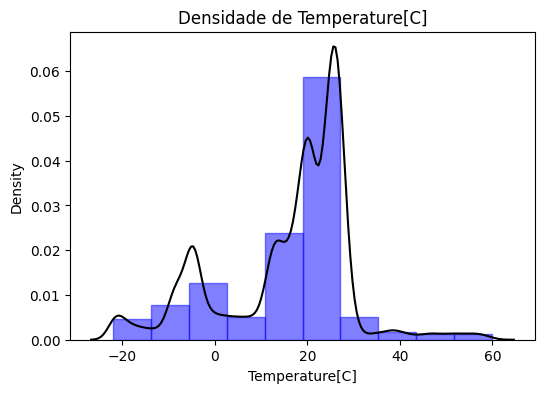

In [37]:
plt.figure(figsize=[6,4])

plt.hist(data = db_smoke_detection, x = 'Temperature[C]', color='blue', histtype='bar', rwidth=2, edgecolor='blue', density=True, alpha=.5)
plt.title("Densidade de Temperature[C]")
sns.kdeplot(db_smoke_detection['Temperature[C]'].dropna(), color='black')

plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


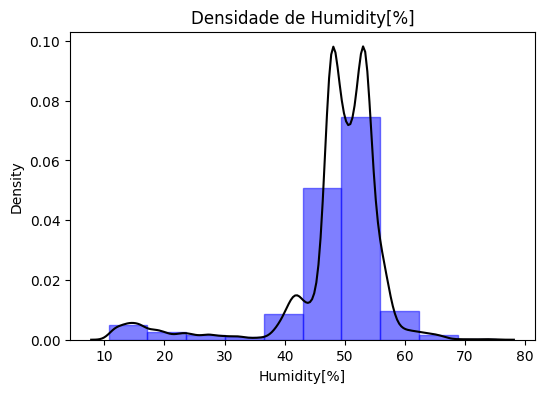

In [38]:
plt.figure(figsize=[6,4])

plt.hist(data = db_smoke_detection, x = 'Humidity[%]', color='blue', histtype='bar', rwidth=2, edgecolor='blue', density=True, alpha=.5)
plt.title("Densidade de Humidity[%]")
sns.kdeplot(db_smoke_detection['Humidity[%]'].dropna(), color='black')

plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


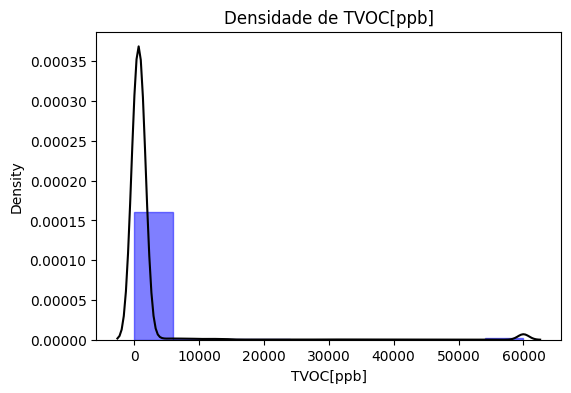

In [39]:
plt.figure(figsize=[6,4])

plt.hist(data = db_smoke_detection, x = 'TVOC[ppb]', color='blue', histtype='bar', rwidth=2, edgecolor='blue', density=True, alpha=.5)
plt.title("Densidade de TVOC[ppb]")
sns.kdeplot(db_smoke_detection['TVOC[ppb]'].dropna(), color='black')

plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


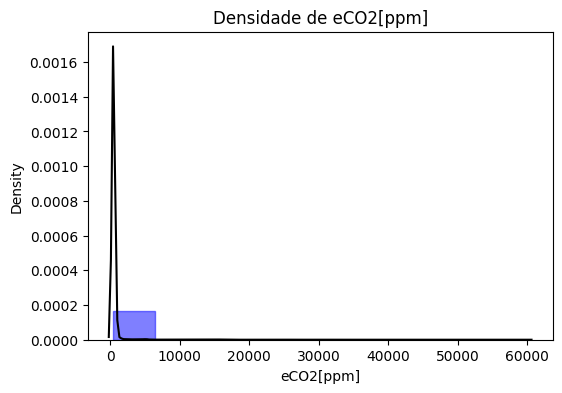

In [40]:
plt.figure(figsize=[6,4])

plt.hist(data = db_smoke_detection, x = 'eCO2[ppm]', color='blue', histtype='bar', rwidth=2, edgecolor='blue', density=True, alpha=.5)
plt.title("Densidade de eCO2[ppm]")
sns.kdeplot(db_smoke_detection['eCO2[ppm]'].dropna(), color='black')

plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


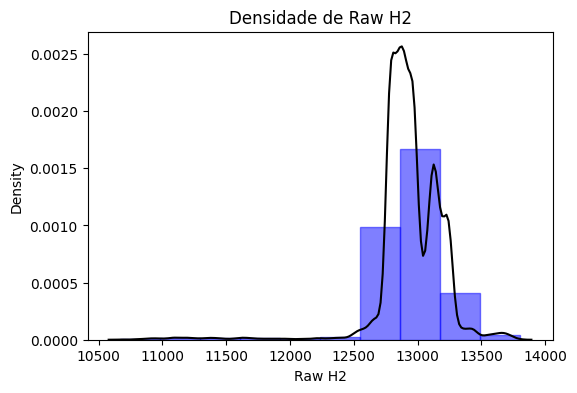

In [41]:
plt.figure(figsize=[6,4])

plt.hist(data = db_smoke_detection, x = 'Raw H2', color='blue', histtype='bar', rwidth=2, edgecolor='blue', density=True, alpha=.5)
plt.title("Densidade de Raw H2")
sns.kdeplot(db_smoke_detection['Raw H2'].dropna(), color='black')

plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


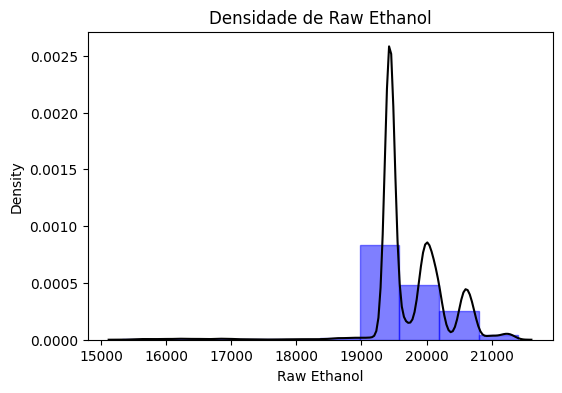

In [42]:
plt.figure(figsize=[6,4])

plt.hist(data = db_smoke_detection, x = 'Raw Ethanol', color='blue', histtype='bar', rwidth=2, edgecolor='blue', density=True, alpha=.5)
plt.title("Densidade de Raw Ethanol")
sns.kdeplot(db_smoke_detection['Raw Ethanol'].dropna(), color='black')

plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


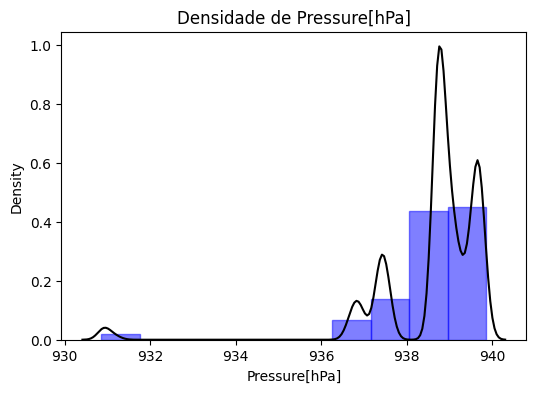

In [43]:
plt.figure(figsize=[6,4])

plt.hist(data = db_smoke_detection, x = 'Pressure[hPa]', color='blue', histtype='bar', rwidth=2, edgecolor='blue', density=True, alpha=.5)
plt.title("Densidade de Pressure[hPa]")
sns.kdeplot(db_smoke_detection['Pressure[hPa]'].dropna(), color='black')

plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


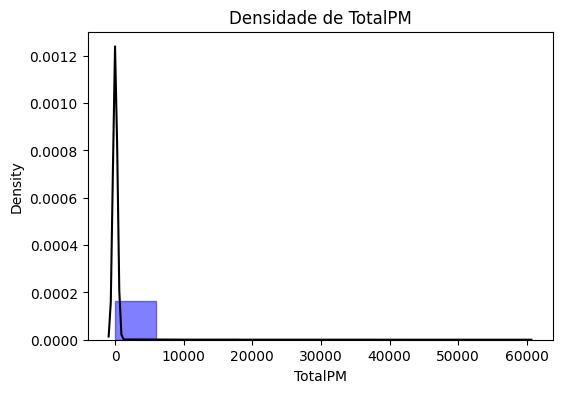

In [44]:
plt.figure(figsize=[6,4])

plt.hist(data = db_smoke_detection, x = 'TotalPM', color='blue', histtype='bar', rwidth=2, edgecolor='blue', density=True, alpha=.5)
plt.title("Densidade de TotalPM")
sns.kdeplot(db_smoke_detection['TotalPM'].dropna(), color='black')

plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


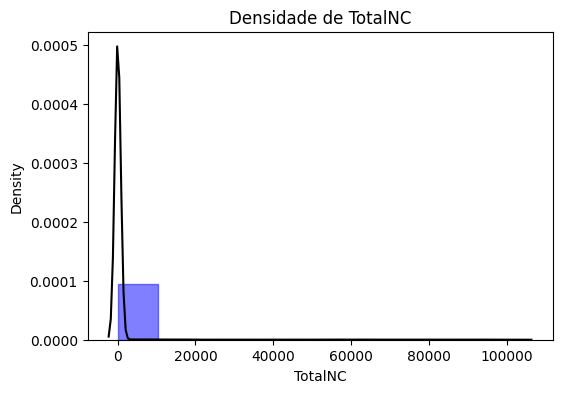

In [45]:
plt.figure(figsize=[6,4])

plt.hist(data = db_smoke_detection, x = 'TotalNC', color='blue', histtype='bar', rwidth=2, edgecolor='blue', density=True, alpha=.5)
plt.title("Densidade de TotalNC")
sns.kdeplot(db_smoke_detection['TotalNC'].dropna(), color='black')

plt.show()

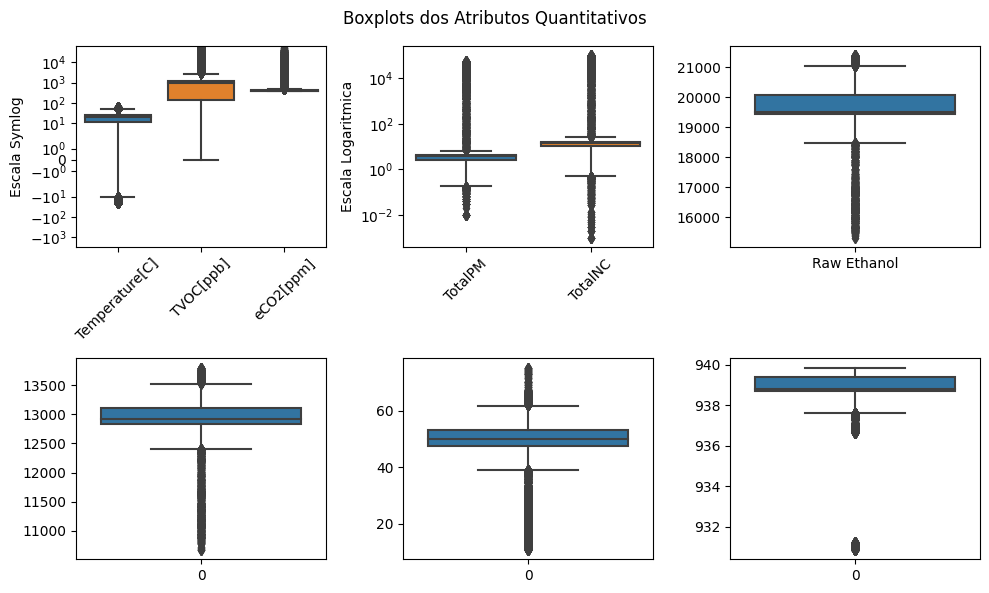

In [46]:
plt.figure(figsize=(10, 6))

plt. subplot(2,3,1)
sns.boxplot(db_smoke_detection[['Temperature[C]', 'TVOC[ppb]', 'eCO2[ppm]']])
plt.yscale('symlog')
plt.ylabel('Escala Symlog')
plt.xticks(rotation=45)

plt.subplot(2,3,2)
sns.boxplot(data=db_smoke_detection[['TotalPM', 'TotalNC']])
plt.yscale('log')
plt.ylabel('Escala Logaritmica')
plt.xticks(rotation=45)

plt.subplot(2,3,3)
sns.boxplot(db_smoke_detection[['Raw Ethanol']])

plt.subplot(2,3,4)
sns.boxplot(db_smoke_detection['Raw H2'])

plt.subplot(2,3,5)
sns.boxplot(db_smoke_detection['Humidity[%]'])

plt.subplot(2,3,6)
sns.boxplot(db_smoke_detection['Pressure[hPa]'])

plt.suptitle('Boxplots dos Atributos Quantitativos')
plt.tight_layout()
plt.show()

### Variáveis Qualitativas

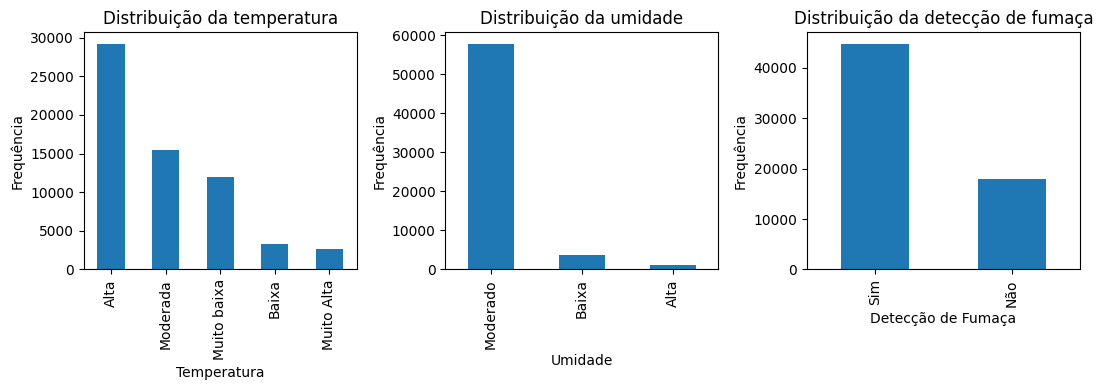

In [47]:
plt.figure(figsize = [11,4])

plt.subplot(1,3,1)
db_smoke_detection['TemperatureCat'].value_counts().plot(kind = 'bar')
plt.title("Distribuição da temperatura")
plt.xlabel("Temperatura")
plt.ylabel("Frequência")

plt.subplot(1,3,2)
db_smoke_detection['HumidityCat'].value_counts().plot(kind='bar')
plt.title("Distribuição da umidade")
plt.xlabel("Umidade")
plt.ylabel("Frequência")

plt.subplot(1,3,3)
db_smoke_detection['SmokeDetec'].value_counts().plot(kind='bar')
plt.title("Distribuição da detecção de fumaça")
plt.xlabel("Detecção de Fumaça")
plt.ylabel("Frequência")

plt.tight_layout()
plt.show()

## Análise Bivariada

### Comparação entre a variável TemperatureCat e SmokeDetec

In [48]:
crossTempSmoke = pd.crosstab(db_smoke_detection.TemperatureCat, db_smoke_detection.SmokeDetec, margins=True)
crossTempSmoke

SmokeDetec,Não,Sim,All
TemperatureCat,,,
Alta,7682,21551,29233
Baixa,661,2616,3277
Moderada,5564,9906,15470
Muito Alta,1719,907,2626
Muito baixa,2247,9777,12024
All,17873,44757,62630


In [49]:
crossTempSmokeRelativa = pd.crosstab(db_smoke_detection.TemperatureCat, db_smoke_detection.SmokeDetec, normalize='columns', margins=True)
crossTempSmokeRelativa

SmokeDetec,Não,Sim,All
TemperatureCat,,,
Alta,0.429810,0.481511,0.466757
Baixa,0.036983,0.058449,0.052323
Moderada,0.311308,0.221329,0.247006
Muito Alta,0.096179,0.020265,0.041929
Muito baixa,0.125720,0.218446,0.191985


In [50]:
crossTempSmokePercLinha = pd.crosstab(db_smoke_detection.TemperatureCat, db_smoke_detection.SmokeDetec, normalize='index', margins=True).round(3)*100
crossTempSmokePercLinha

SmokeDetec,Não,Sim
TemperatureCat,,
Alta,26.3,73.7
Baixa,20.2,79.8
Moderada,36.0,64.0
Muito Alta,65.5,34.5
Muito baixa,18.7,81.3
All,28.5,71.5


In [51]:
crossTempSmokePercTotal = pd.crosstab(db_smoke_detection.TemperatureCat, db_smoke_detection.SmokeDetec, normalize=True, margins=True).round(3)*100
crossTempSmokePercTotal

SmokeDetec,Não,Sim,All
TemperatureCat,,,
Alta,12.3,34.4,46.7
Baixa,1.1,4.2,5.2
Moderada,8.9,15.8,24.7
Muito Alta,2.7,1.4,4.2
Muito baixa,3.6,15.6,19.2
All,28.5,71.5,100.0


### Comparação entre a variável HumidityCat e SmokeDetec

In [52]:
crossHumidSmoke = pd.crosstab(db_smoke_detection.HumidityCat, db_smoke_detection.SmokeDetec, margins=True)
crossHumidSmoke

SmokeDetec,Não,Sim,All
HumidityCat,,,
Alta,218,850,1068
Baixa,2798,866,3664
Moderado,14857,43041,57898
All,17873,44757,62630


In [53]:
crossHumidSmokeRelativa = pd.crosstab(db_smoke_detection.HumidityCat, db_smoke_detection.SmokeDetec, normalize='columns', margins=True)
crossHumidSmokeRelativa

SmokeDetec,Não,Sim,All
HumidityCat,,,
Alta,0.012197,0.018991,0.017053
Baixa,0.156549,0.019349,0.058502
Moderado,0.831254,0.961660,0.924445


In [54]:
crossHumidSmokePercLinha = pd.crosstab(db_smoke_detection.HumidityCat, db_smoke_detection.SmokeDetec, normalize='index', margins=True).round(3)*100
crossHumidSmokePercLinha

SmokeDetec,Não,Sim
HumidityCat,,
Alta,20.4,79.6
Baixa,76.4,23.6
Moderado,25.7,74.3
All,28.5,71.5


In [55]:
crossHumidSmokePercTotal = pd.crosstab(db_smoke_detection.HumidityCat, db_smoke_detection.SmokeDetec, normalize=True, margins=True).round(3)*100
crossHumidSmokePercTotal

SmokeDetec,Não,Sim,All
HumidityCat,,,
Alta,0.3,1.4,1.7
Baixa,4.5,1.4,5.9
Moderado,23.7,68.7,92.4
All,28.5,71.5,100.0


### Coeficiente de Correlação de Pearson

- Correlação Geral

In [56]:
db_smoke_detection[db_quantitativos+['Fire Alarm']].corr()

,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],TotalPM,TotalNC,Fire Alarm
Temperature[C],1.000000,-0.243986,0.082442,0.079265,-0.135540,-0.037343,-0.251203,0.034079,0.037665,-0.163902
Humidity[%],-0.243986,1.000000,-0.488878,-0.369095,0.247199,0.068782,0.694614,-0.199135,-0.241031,0.399846
TVOC[ppb],0.082442,-0.488878,1.000000,0.606118,-0.653053,-0.673715,-0.220004,0.520575,0.606222,-0.214743
eCO2[ppm],0.079265,-0.369095,0.606118,1.000000,-0.682785,-0.506695,-0.326043,0.608037,0.671384,-0.097006
Raw H2,-0.135540,0.247199,-0.653053,-0.682785,1.000000,0.631495,0.303090,-0.467257,-0.537910,0.107007
Raw Ethanol,-0.037343,0.068782,-0.673715,-0.506695,0.631495,1.000000,-0.075926,-0.425107,-0.486949,-0.340652
Pressure[hPa],-0.251203,0.694614,-0.220004,-0.326043,0.303090,-0.075926,1.000000,-0.250517,-0.259271,0.249797
TotalPM,0.034079,-0.199135,0.520575,0.608037,-0.467257,-0.425107,-0.250517,1.000000,0.973322,-0.093974
TotalNC,0.037665,-0.241031,0.606222,0.671384,-0.537910,-0.486949,-0.259271,0.973322,1.000000,-0.112525
Fire Alarm,-0.163902,0.399846,-0.214743,-0.097006,0.107007,-0.340652,0.249797,-0.093974,-0.112525,1.000000


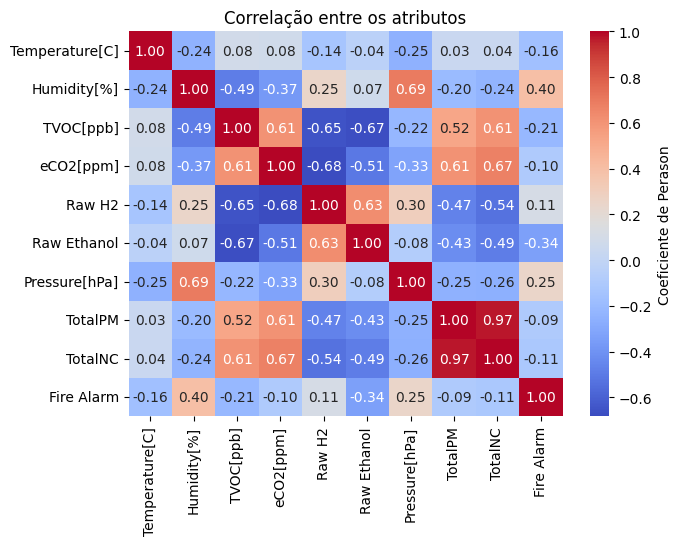

In [57]:
plt.figure(figsize=[7,5])

sns.heatmap(data=(db_smoke_detection[db_quantitativos+['Fire Alarm']]).corr(), cmap='coolwarm', annot=True, fmt='.2f', cbar_kws={'label': 'Coeficiente de Perason'})
plt.title('Correlação entre os atributos')

plt.show()

#### Criação de Subgrupos

In [58]:
no_smoke = db_smoke_detection['Fire Alarm']==0
smoke = db_smoke_detection['Fire Alarm']==1

#### Criação dos Gráficos

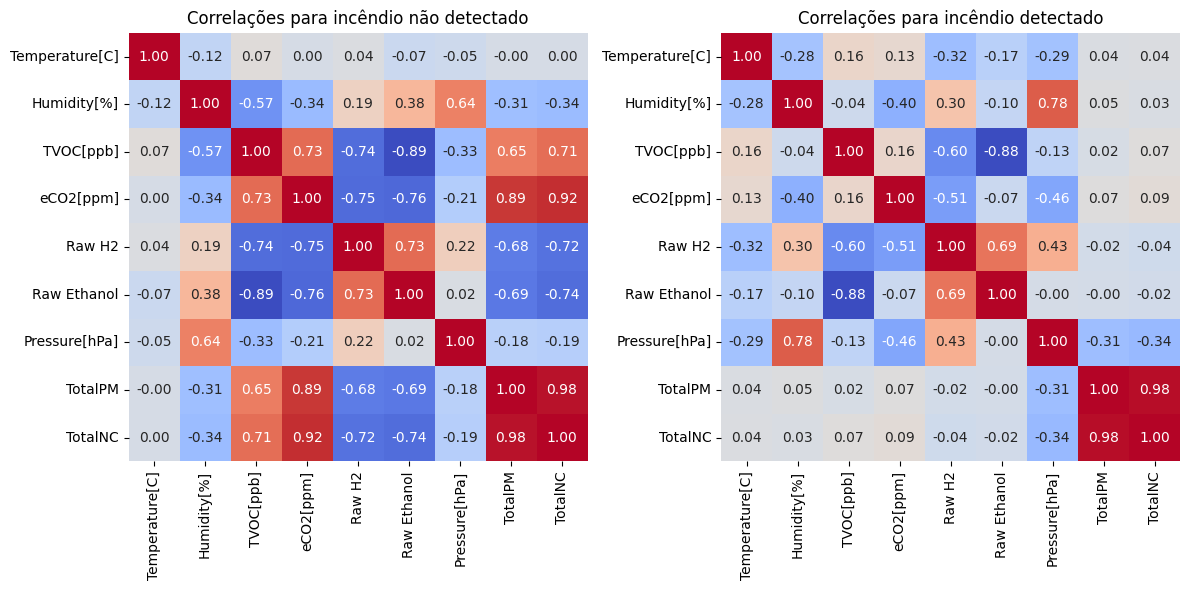

In [59]:
plt.figure(figsize=[12,6])

plt.subplot(1,2,1)
sns.heatmap(data=(db_smoke_detection[no_smoke][db_quantitativos]).corr(), cmap='coolwarm', annot=True, fmt='.2f', cbar = False)
plt.title('Correlações para incêndio não detectado')

plt.subplot(1,2,2)
sns.heatmap(data=(db_smoke_detection[smoke][db_quantitativos]).corr(), cmap='coolwarm', annot=True, fmt='.2f', cbar = False)
plt.title('Correlações para incêndio detectado')

plt.tight_layout()
plt.show()

##### Gráficos de Dispersão

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

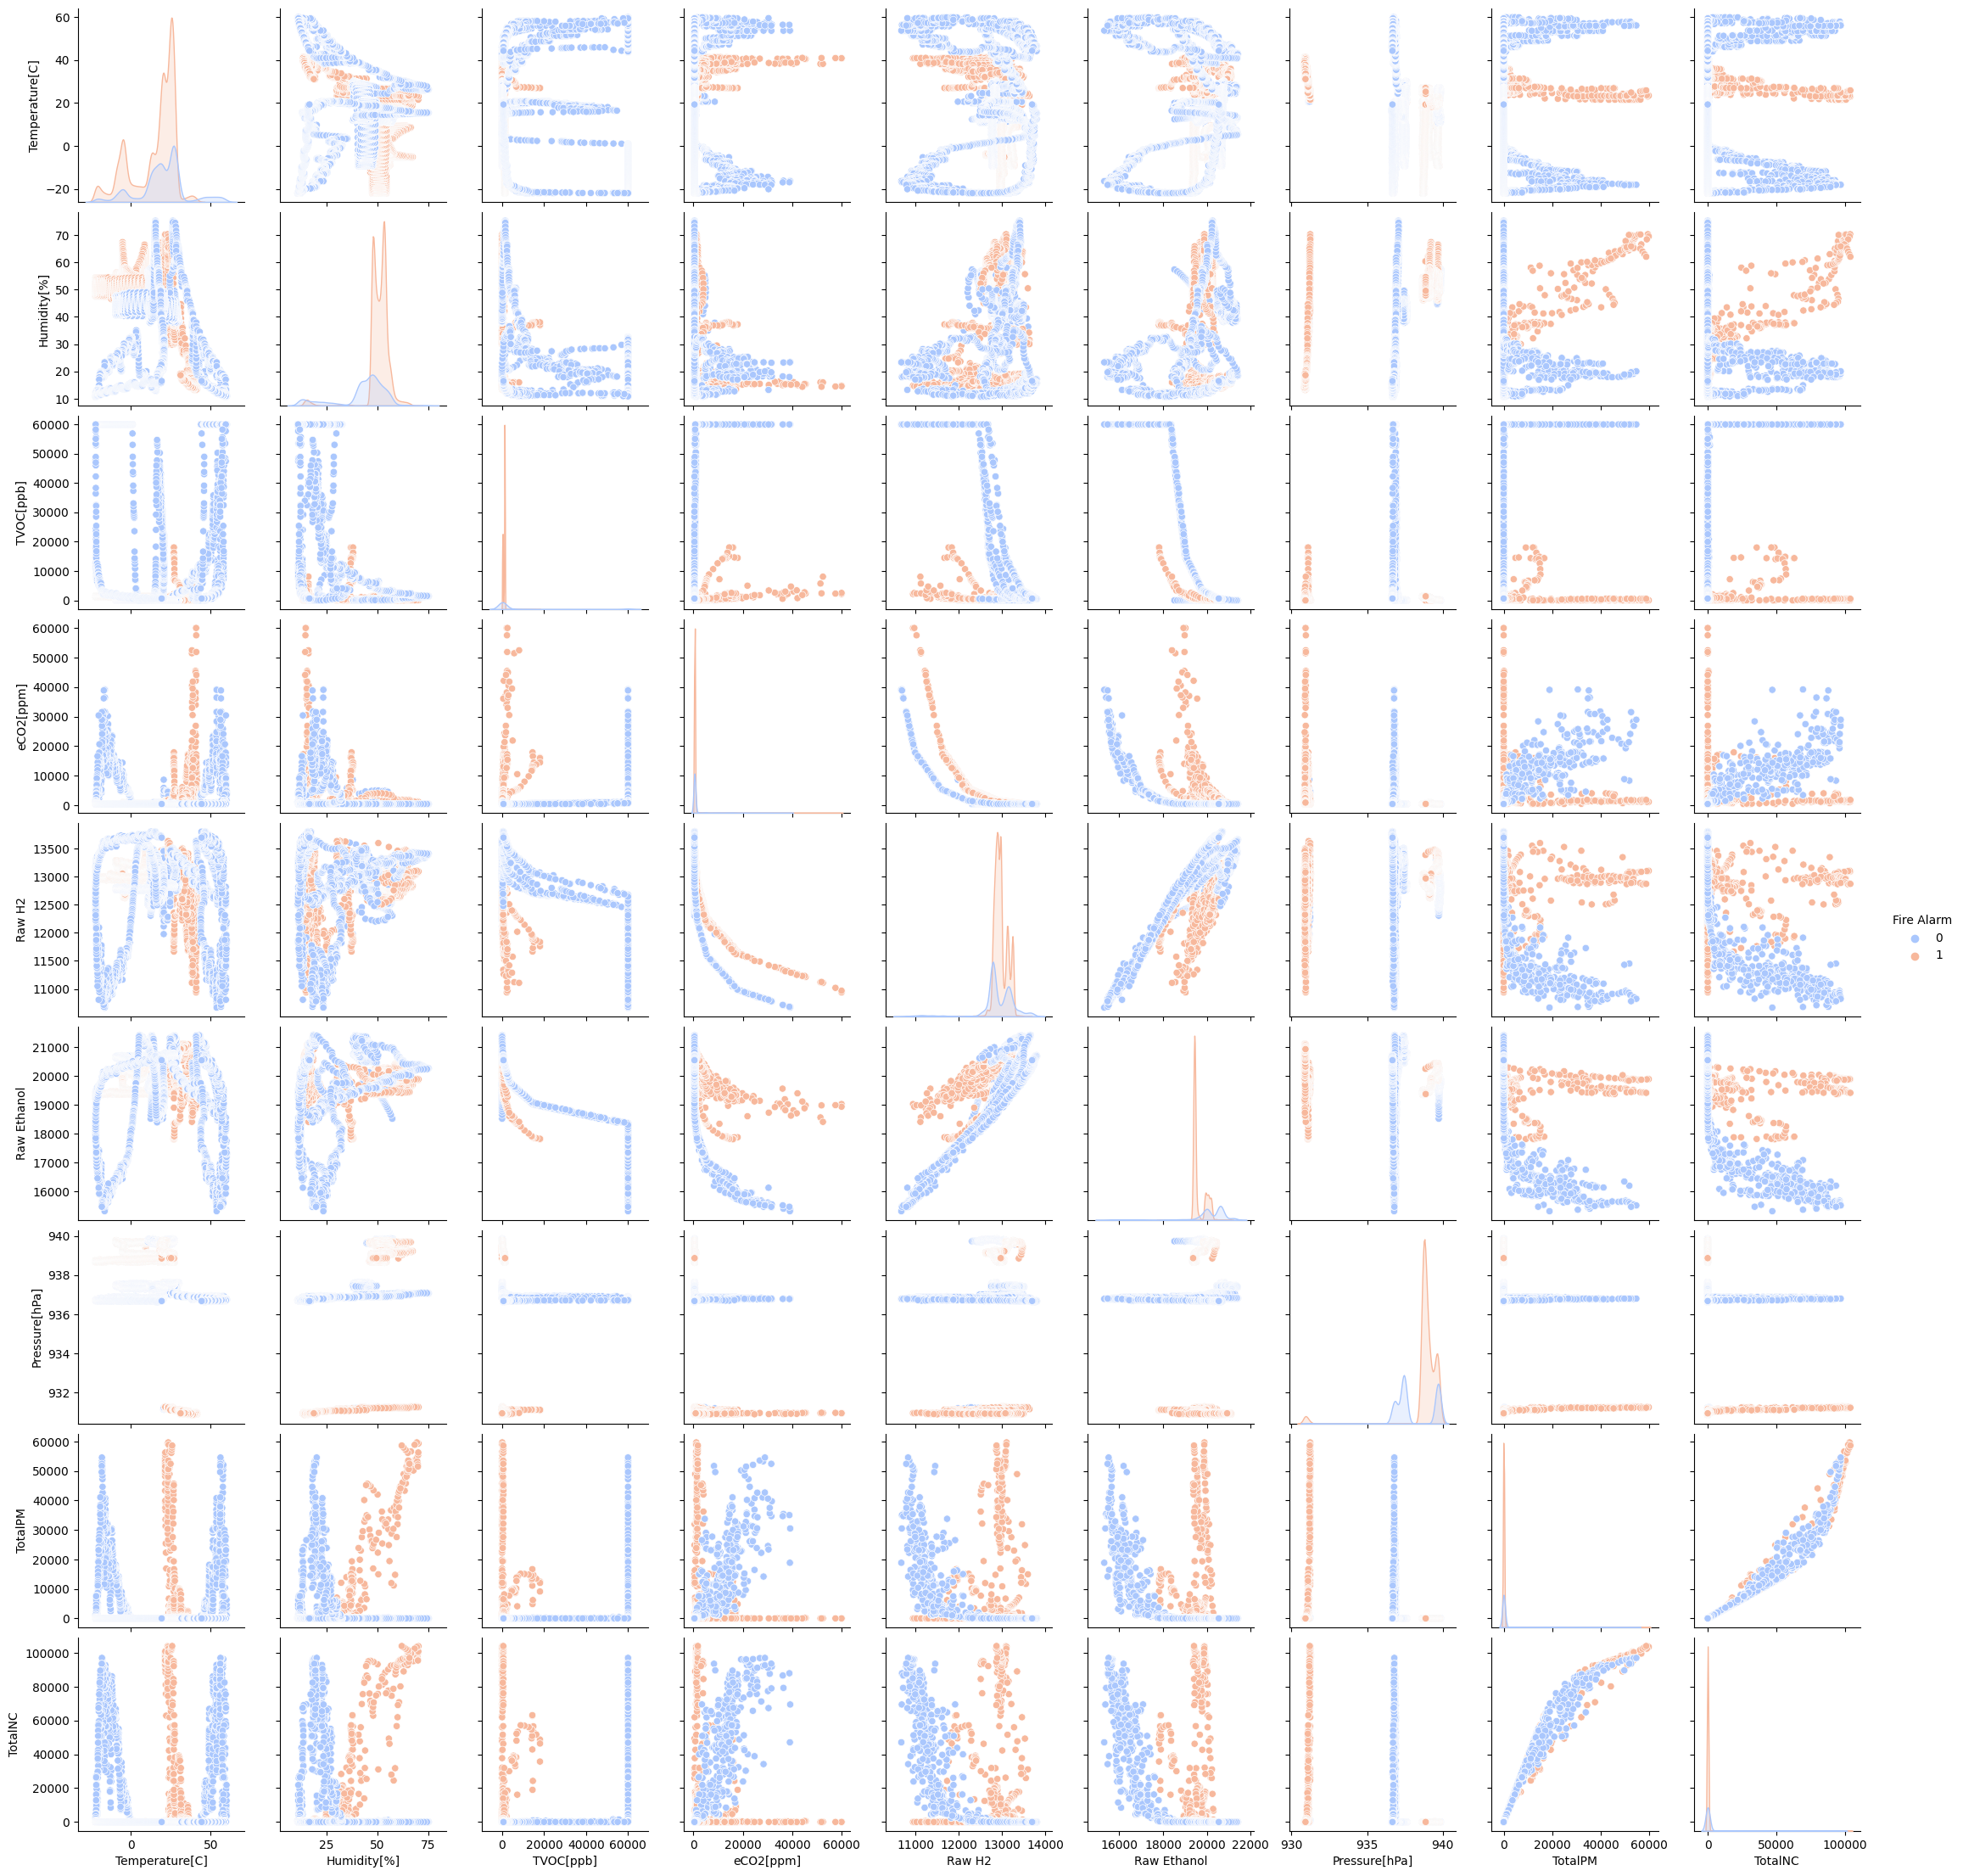

In [60]:
sns.pairplot(db_smoke_detection[db_quantitativos + ['Fire Alarm']], hue='Fire Alarm', diag_kind='kde', palette='coolwarm')
plt.show()

###### Gráficos de dispersão relevantes para correlação geral

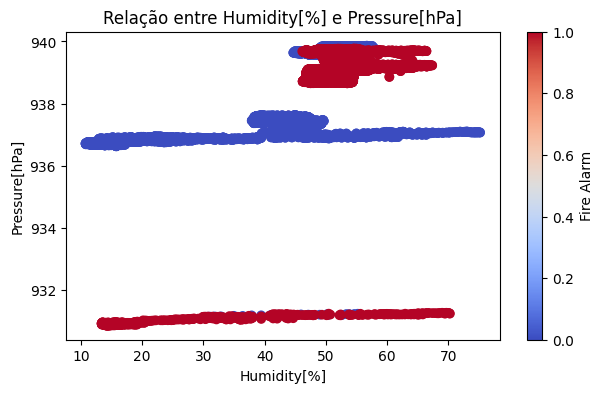

In [61]:
plt.figure(figsize=[7,4])

plt.scatter('Humidity[%]', 'Pressure[hPa]', data = db_smoke_detection, c = 'Fire Alarm', cmap='coolwarm')
plt.colorbar(label='Fire Alarm')
plt.title('Relação entre Humidity[%] e Pressure[hPa]')
plt.xlabel('Humidity[%]')
plt.ylabel('Pressure[hPa]')

plt.show()

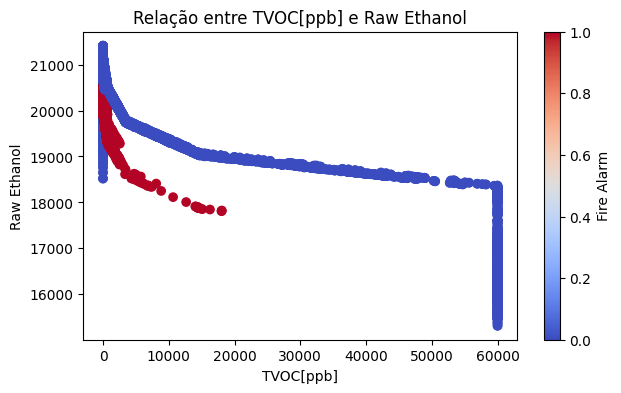

In [62]:
plt.figure(figsize=[7,4])

plt.scatter('TVOC[ppb]', 'Raw Ethanol', data = db_smoke_detection, c = 'Fire Alarm', cmap='coolwarm')
plt.colorbar(label='Fire Alarm')
plt.title('Relação entre TVOC[ppb] e Raw Ethanol')
plt.xlabel('TVOC[ppb]')
plt.ylabel('Raw Ethanol')

plt.show()

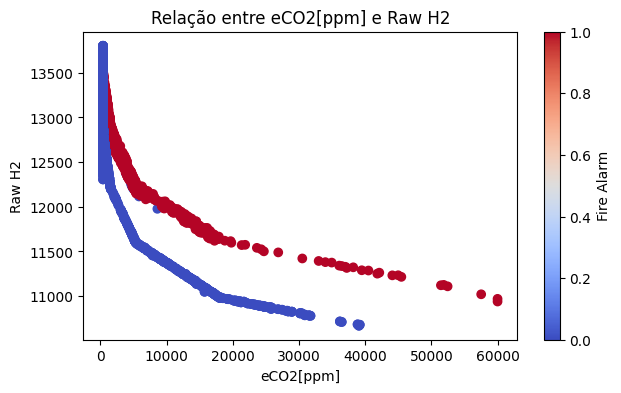

In [63]:
plt.figure(figsize=[7,4])

plt.scatter('eCO2[ppm]', 'Raw H2', data = db_smoke_detection, c = 'Fire Alarm', cmap='coolwarm')
plt.colorbar(label='Fire Alarm')
plt.title('Relação entre eCO2[ppm] e Raw H2')
plt.xlabel('eCO2[ppm]')
plt.ylabel('Raw H2')

plt.show()

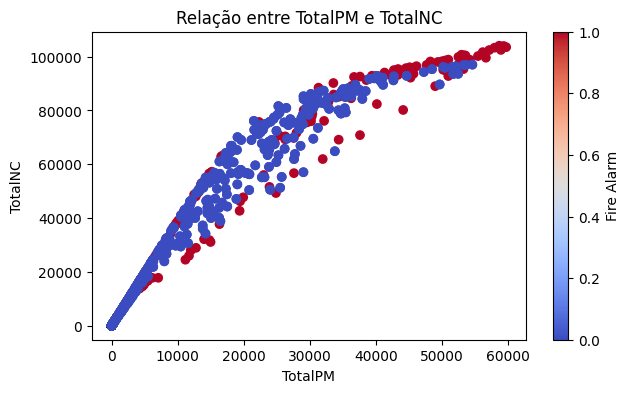

In [64]:
plt.figure(figsize=[7,4])

plt.scatter('TotalPM', 'TotalNC', data = db_smoke_detection, c = 'Fire Alarm', cmap='coolwarm')
plt.colorbar(label='Fire Alarm')
plt.title('Relação entre TotalPM e TotalNC')
plt.xlabel('TotalPM')
plt.ylabel('TotalNC')

plt.show()

###### Gráficos de dispersão relevantes para presença de incêndio

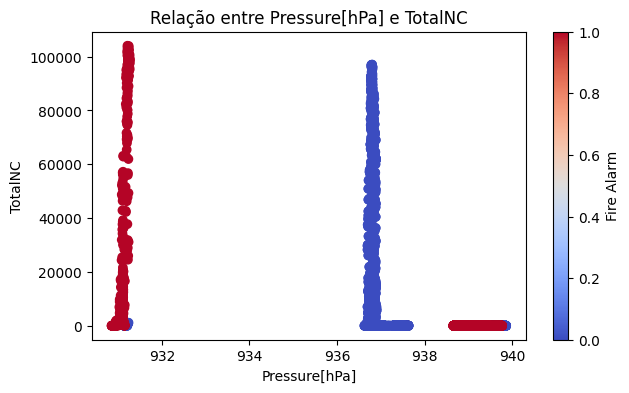

In [65]:
plt.figure(figsize=[7,4])

plt.scatter('Pressure[hPa]', 'TotalNC', data = db_smoke_detection, c = 'Fire Alarm', cmap='coolwarm')
plt.colorbar(label='Fire Alarm')
plt.title('Relação entre Pressure[hPa] e TotalNC')
plt.xlabel('Pressure[hPa]')
plt.ylabel('TotalNC')

plt.show()

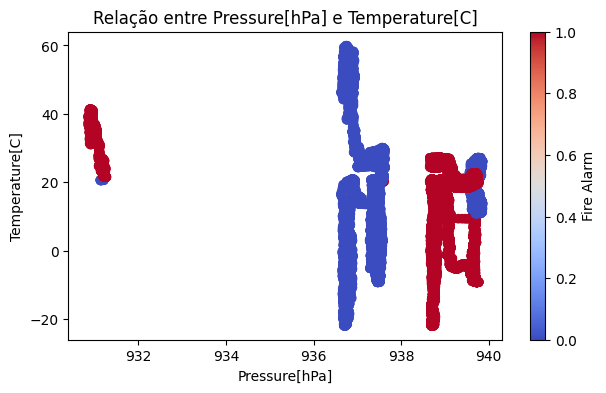

In [66]:
plt.figure(figsize=[7,4])

plt.scatter('Pressure[hPa]', 'Temperature[C]', data = db_smoke_detection, c = 'Fire Alarm', cmap='coolwarm')
plt.colorbar(label='Fire Alarm')
plt.title('Relação entre Pressure[hPa] e Temperature[C]')
plt.xlabel('Pressure[hPa]')
plt.ylabel('Temperature[C]')

plt.show()

## Inferência Estatística

#### Teste de Normalidade

In [67]:
pg.normality(db_smoke_detection, method='normaltest').round(3)

,W,pval,normal
Temperature[C],3777.238,0.0,False
Humidity[%],31819.141,0.0,False
TVOC[ppb],75308.250,0.0,False
eCO2[ppm],109080.446,0.0,False
Raw H2,42259.396,0.0,False
Raw Ethanol,26587.103,0.0,False
Pressure[hPa],47769.449,0.0,False
PM1.0,99949.340,0.0,False
PM2.5,115678.264,0.0,False
NC0.5,96152.797,0.0,False


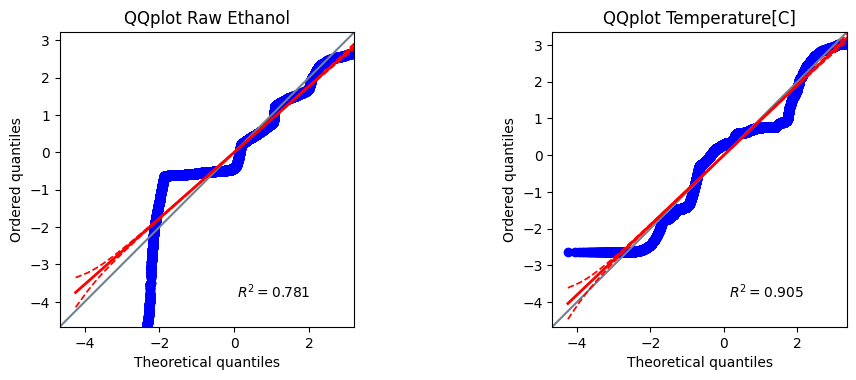

In [68]:
plt.figure(figsize = (10,7))

plt.subplot(2,2,1)
pg.qqplot(db_smoke_detection['Raw Ethanol'], dist='norm')
plt.title('QQplot Raw Ethanol')


plt.subplot(2,2,2)
pg.qqplot(db_smoke_detection['Temperature[C]'], dist='norm')
plt.title('QQplot Temperature[C]')

plt.tight_layout()
plt.show()

**Utilização do subgrupo com Fire Alarm = 1**

In [69]:
db_smoke = db_smoke_detection[smoke]
db_smoke

,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],PM1.0,PM2.5,NC0.5,NC1.0,NC2.5,Fire Alarm,TemperatureCat,HumidityCat,SmokeDetec,TotalNC,TotalPM
3178,9.381,56.86,11,400,13347,20160,939.575,1.78,1.85,12.25,1.911,0.043,1,Baixa,Moderado,Sim,14.204,3.63
3179,9.368,58.60,0,400,13385,20202,939.574,1.80,1.87,12.41,1.935,0.044,1,Baixa,Moderado,Sim,14.389,3.67
3180,9.356,60.38,0,400,13388,20248,938.858,1.94,2.01,13.32,2.077,0.047,1,Baixa,Alta,Sim,15.444,3.95
3181,9.343,62.22,0,400,13443,20315,939.044,2.00,2.08,13.75,2.145,0.048,1,Baixa,Alta,Sim,15.943,4.08
3182,9.331,63.11,0,400,13457,20348,939.193,2.07,2.15,14.24,2.220,0.050,1,Baixa,Alta,Sim,16.510,4.22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51141,31.120,18.67,0,873,13077,20927,930.929,1.00,1.04,6.89,1.075,0.024,1,Muito Alta,Baixa,Sim,7.989,2.04
51145,27.320,43.84,29,454,12858,20752,937.610,2.24,2.32,15.39,2.400,0.054,1,Alta,Moderado,Sim,17.844,4.56
51146,27.270,43.98,28,456,12860,20751,937.601,2.26,2.35,15.58,2.429,0.055,1,Alta,Moderado,Sim,18.064,4.61
56889,20.191,43.84,29,454,12858,20752,937.610,2.24,2.32,15.39,2.400,0.054,1,Alta,Moderado,Sim,17.844,4.56


In [70]:
pg.normality(db_smoke[db_quantitativos + ['PM1.0', 'PM2.5', 'NC0.5', 'NC1.0', 'NC2.5']], method='normaltest').round(3)

,W,pval,normal
Temperature[C],5029.847,0.0,False
Humidity[%],35153.038,0.0,False
TVOC[ppb],56419.022,0.0,False
eCO2[ppm],107695.062,0.0,False
Raw H2,16447.269,0.0,False
Raw Ethanol,7513.566,0.0,False
Pressure[hPa],45867.043,0.0,False
TotalPM,101227.394,0.0,False
TotalNC,95833.057,0.0,False
PM1.0,96475.966,0.0,False


**Utilização do subgrupo com Fire Alarm = 0**

In [71]:
db_no_smoke = db_smoke_detection[no_smoke]
db_no_smoke

,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],PM1.0,PM2.5,NC0.5,NC1.0,NC2.5,Fire Alarm,TemperatureCat,HumidityCat,SmokeDetec,TotalNC,TotalPM
0,20.000,57.36,0,400,12306,18520,939.735,0.00,0.00,0.00,0.000,0.000,0,Alta,Moderado,Não,0.000,0.00
1,20.015,56.67,0,400,12345,18651,939.744,0.00,0.00,0.00,0.000,0.000,0,Alta,Moderado,Não,0.000,0.00
2,20.029,55.96,0,400,12374,18764,939.738,0.00,0.00,0.00,0.000,0.000,0,Alta,Moderado,Não,0.000,0.00
3,20.044,55.28,0,400,12390,18849,939.736,0.00,0.00,0.00,0.000,0.000,0,Alta,Moderado,Não,0.000,0.00
4,20.059,54.69,0,400,12403,18921,939.744,0.00,0.00,0.00,0.000,0.000,0,Alta,Moderado,Não,0.000,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62625,18.438,15.79,625,400,13723,20569,936.670,0.63,0.65,4.32,0.673,0.015,0,Moderada,Baixa,Não,5.008,1.28
62626,18.653,15.87,612,400,13731,20588,936.678,0.61,0.63,4.18,0.652,0.015,0,Moderada,Baixa,Não,4.847,1.24
62627,18.867,15.84,627,400,13725,20582,936.687,0.57,0.60,3.95,0.617,0.014,0,Moderada,Baixa,Não,4.581,1.17
62628,19.083,16.04,638,400,13712,20566,936.680,0.57,0.59,3.92,0.611,0.014,0,Moderada,Baixa,Não,4.545,1.16


In [72]:
pg.normality(db_no_smoke[db_quantitativos + ['PM1.0', 'PM2.5', 'NC0.5', 'NC1.0', 'NC2.5']], method='normaltest').round(3)

,W,pval,normal
Temperature[C],394.628,0.0,False
Humidity[%],3221.830,0.0,False
TVOC[ppb],11982.597,0.0,False
eCO2[ppm],21501.045,0.0,False
Raw H2,8114.609,0.0,False
Raw Ethanol,9646.530,0.0,False
Pressure[hPa],64.972,0.0,False
TotalPM,22984.929,0.0,False
TotalNC,20148.525,0.0,False
PM1.0,20379.889,0.0,False


#### Teste com múltiplas amostras

##### Teste de Homocedasticidade

In [73]:
data=[list(db_smoke['Pressure[hPa]']), list(db_no_smoke['Pressure[hPa]'])]
pg.homoscedasticity(data,method="bartlett")

,T,pval,equal_var
bartlett,78.312164,8.797842e-19,False


In [74]:
pg.homoscedasticity(data,method="levene")

,W,pval,equal_var
levene,2309.067202,0.0,False


##### Teste Qui-Quadrado

**Teste Qui-Quadrado para TemperatureCat e SmokeDetec**

In [75]:
temp_expected, temp_observed, temp_stats = pg.chi2_independence(db_smoke_detection, x='TemperatureCat', y='SmokeDetec')

In [76]:
temp_observed.round(0)

SmokeDetec,Não,Sim
TemperatureCat,,
Alta,7682,21551
Baixa,661,2616
Moderada,5564,9906
Muito Alta,1719,907
Muito baixa,2247,9777


In [77]:
temp_expected.round(2)

SmokeDetec,Não,Sim
TemperatureCat,,
Alta,8342.35,20890.65
Baixa,935.17,2341.83
Moderada,4414.74,11055.26
Muito Alta,749.39,1876.61
Muito baixa,3431.34,8592.66


In [78]:
temp_testeqq = temp_stats
temp_testeqq

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000000,2931.803845,4.0,0.0,0.216360,1.0
1,cressie-read,0.666667,2848.555497,4.0,0.0,0.213266,1.0
2,log-likelihood,0.000000,2752.675310,4.0,0.0,0.209646,1.0
3,freeman-tukey,-0.500000,2735.322665,4.0,0.0,0.208984,1.0
4,mod-log-likelihood,-1.000000,2761.021288,4.0,0.0,0.209963,1.0
5,neyman,-2.000000,2941.319515,4.0,0.0,0.216710,1.0


**Teste Qui-Quadrado para HumidityCat e SmokeDetec**

In [79]:
hum_expected, hum_observed, hum_stats = pg.chi2_independence(db_smoke_detection, x='HumidityCat', y='SmokeDetec')

In [80]:
hum_observed.round(0)

SmokeDetec,Não,Sim
HumidityCat,,
Alta,218,850
Baixa,2798,866
Moderado,14857,43041


In [81]:
hum_expected.round(2)

SmokeDetec,Não,Sim
HumidityCat,,
Alta,304.78,763.22
Baixa,1045.61,2618.39
Moderado,16522.61,41375.39


In [82]:
hum_testeqq = hum_stats
hum_testeqq

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000000,4379.246362,2.0,0.0,0.264429,1.0
1,cressie-read,0.666667,4129.675982,2.0,0.0,0.256783,1.0
2,log-likelihood,0.000000,3868.813449,2.0,0.0,0.248541,1.0
3,freeman-tukey,-0.500000,3862.832109,2.0,0.0,0.248349,1.0
4,mod-log-likelihood,-1.000000,4021.026364,2.0,0.0,0.253383,1.0
5,neyman,-2.000000,4938.144245,2.0,0.0,0.280796,1.0


##### Teste de Correlação e Regressão

###### Teste de Correlação e Regressão entre TotalPM e TotalNC

In [83]:
db_smoke_detection['TotalPM'].corr(db_smoke_detection['TotalNC'], method='pearson')

0.973322249411413

In [84]:
pg.corr(db_smoke_detection['TotalPM'], db_smoke_detection['TotalNC'], method='pearson').round(5)

,n,r,CI95%,p-val,BF10,power
pearson,62630,0.97332,"[0.97, 0.97]",0.0,nan,1.0


In [85]:
pg.corr(db_smoke_detection['TotalPM'], db_smoke_detection['TotalNC'], method='spearman').round(5)

,n,r,CI95%,p-val,power
spearman,62630,0.99952,"[1.0, 1.0]",0.0,1.0


In [86]:
lmPMNC = pg.linear_regression(db_smoke_detection['TotalPM'], db_smoke_detection['TotalNC'])
lmPMNC

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,94.512447,6.488606,14.565909,5.545996e-48,0.947356,0.947355,81.794766,107.230128
1,TotalPM,2.387503,0.002249,1061.615650,0.000000e+00,0.947356,0.947355,2.383096,2.391911


In [87]:
# Coeficientes
a_PMNC = lmPMNC['coef'][1]
b_PMNC = lmPMNC['coef'][0]

#R^2
r2_PMNC = lmPMNC['r2'][0]

# Equação da regressão
equacao_regressao = f"Y = {a_PMNC:.2f} * X + {b_PMNC:.2f} (R² = {r2_PMNC:.2f})"
print("Equação da regressão linear:", equacao_regressao)

Equação da regressão linear: Y = 2.39 * X + 94.51 (R² = 0.95)


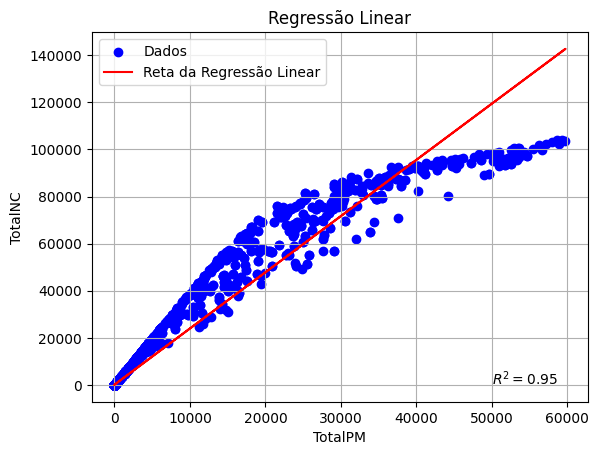

In [88]:
plt.scatter('TotalPM', 'TotalNC', data = db_smoke_detection, color='blue', label='Dados')
plt.plot(db_smoke_detection['TotalPM'], a_PMNC * db_smoke_detection['TotalPM'] + b_PMNC, color='red', label='Reta da Regressão Linear')

plt.title('Regressão Linear')
plt.xlabel('TotalPM')
plt.ylabel('TotalNC')
plt.legend()
plt.text(50000, 30, f'$R^2 = {r2_PMNC:.2f}$', fontsize=10)

plt.grid(True)
plt.show()

###### Teste de Correlação e Regressão entre Humidity[%] e Pressure[hPa]

In [89]:
pg.corr(db_smoke_detection['Humidity[%]'], db_smoke_detection['Pressure[hPa]'], method='pearson').round(5)

,n,r,CI95%,p-val,BF10,power
pearson,62630,0.69461,"[0.69, 0.7]",0.0,inf,1.0


In [90]:
pg.corr(db_smoke_detection['Humidity[%]'], db_smoke_detection['Pressure[hPa]'], method='spearman').round(5)

,n,r,CI95%,p-val,power
spearman,62630,0.5558,"[0.55, 0.56]",0.0,1.0


In [91]:
lmHP = pg.linear_regression(db_smoke_detection['Humidity[%]'], db_smoke_detection['Pressure[hPa]'])
lmHP

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,933.564364,0.021300,43828.307923,0.0,0.482489,0.482481,933.522615,933.606113
1,Humidity[%],0.104313,0.000432,241.639660,0.0,0.482489,0.482481,0.103467,0.105159


In [92]:
# Coeficientes
a_HP = lmHP['coef'][1]
b_HP = lmHP['coef'][0]

#R^2
r2_HP = lmHP['r2'][0]

# Equação da regressão
equacao_regressao = f"Y = {a_HP:.2f} * X + {b_HP:.2f} (R² = {r2_HP:.2f})"
print("Equação da regressão linear:", equacao_regressao)

Equação da regressão linear: Y = 0.10 * X + 933.56 (R² = 0.48)


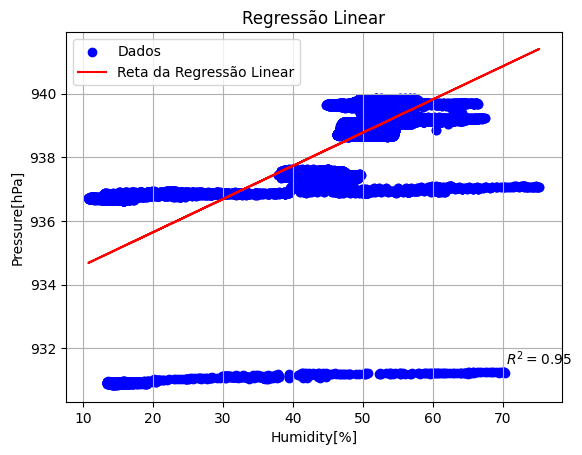

In [93]:
plt.scatter('Humidity[%]', 'Pressure[hPa]', data = db_smoke_detection, color='blue', label='Dados')
plt.plot(db_smoke_detection['Humidity[%]'], a_HP * db_smoke_detection['Humidity[%]'] + b_HP, color='red', label='Reta da Regressão Linear')

plt.title('Regressão Linear')
plt.xlabel('Humidity[%]')
plt.ylabel('Pressure[hPa]')
plt.legend()
plt.text(70.5, 931.5, f'$R^2 = {r2_PMNC:.2f}$', fontsize=10)

plt.grid(True)
plt.show()

###### Teste de Regressão Múltipla entre Raw H2, eCO2, Raw Ethanol, TotalNC, TotalPM e TVOC[ppb]

In [94]:
lmVOC = pg.linear_regression(db_smoke_detection[['Raw H2','eCO2[ppm]', 'Raw Ethanol', 'TotalNC','TotalPM']], db_smoke_detection['TVOC[ppb]'])
lmVOC

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,157537.348837,1307.939393,120.446979,0.000000e+00,0.62454,0.62451,154973.785185,160100.912489
1,Raw H2,-5.441820,0.108709,-50.058602,0.000000e+00,0.62454,0.62451,-5.654890,-5.228750
2,eCO2[ppm],0.327526,0.015961,20.520828,2.848332e-93,0.62454,0.62451,0.296243,0.358809
3,Raw Ethanol,-4.337027,0.041834,-103.672292,0.000000e+00,0.62454,0.62451,-4.419022,-4.255033
4,TotalNC,1.108983,0.013664,81.160974,0.000000e+00,0.62454,0.62451,1.082202,1.135765
5,TotalPM,-1.996243,0.030872,-64.661996,0.000000e+00,0.62454,0.62451,-2.056752,-1.935734


In [95]:
# Coeficientes
i_VOC = lmVOC['coef'][0]
a_VOC = lmVOC['coef'][1]
b_VOC = lmVOC['coef'][2]
c_VOC = lmVOC['coef'][3]
d_VOC = lmVOC['coef'][4]
e_VOC = lmVOC['coef'][5]

#R^2
r2_VOC = lmVOC['r2'][0]

# Equação da regressão
equacao_regressao = f"Y = {a_VOC:.2f} * RH + {b_VOC:.2f} * C + {c_VOC:.2f} * RE + {d_VOC:.2f} * NC + {e_VOC:.2f} * PM + {i_VOC:.2f} (R² = {r2_VOC:.2f})"
print("Equação da regressão linear:", equacao_regressao)

Equação da regressão linear: Y = -5.44 * RH + 0.33 * C + -4.34 * RE + 1.11 * NC + -2.00 * PM + 157537.35 (R² = 0.62)


## Machine Learning

In [96]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import classification_report, accuracy_score, mean_squared_error
from yellowbrick.classifier import ConfusionMatrix
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

### Pré-Processamento dos dados para aplicação das técnicas de machine learning

In [97]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline

Os dados já receberam alguns tratamentos, como a eliminação de atributos redundantes. Agora, é necessário escalonar os dados e codificar os aributos categóricos.

#### Codificação e padronização dos atributos

In [98]:
atributos_num = db_quantitativos + ['PM1.0', 'PM2.5', 'NC0.5', 'NC1.0', 'NC2.5']
atributos_cat = db_qualitativos[0:2]

In [99]:
num_pipeline = Pipeline([('std_scaler', StandardScaler())])
db_numericos_tr = pd.DataFrame(num_pipeline.fit_transform(db_smoke_detection[atributos_num]), columns=atributos_num)
db_numericos_tr

,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],TotalPM,TotalNC,PM1.0,PM2.5,NC0.5,NC1.0,NC2.5
0,0.280622,0.994947,-0.248614,-0.141679,-2.335935,-2.025006,0.831761,-0.099288,-0.110059,-0.109043,-0.093340,-0.115215,-0.091924,-0.073889
1,0.281666,0.917115,-0.248614,-0.141679,-2.192796,-1.810079,0.838521,-0.099288,-0.110059,-0.109043,-0.093340,-0.115215,-0.091924,-0.073889
2,0.282641,0.837028,-0.248614,-0.141679,-2.086359,-1.624683,0.834014,-0.099288,-0.110059,-0.109043,-0.093340,-0.115215,-0.091924,-0.073889
3,0.283686,0.760324,-0.248614,-0.141679,-2.027636,-1.485227,0.832512,-0.099288,-0.110059,-0.109043,-0.093340,-0.115215,-0.091924,-0.073889
4,0.284730,0.693773,-0.248614,-0.141679,-1.979923,-1.367099,0.838521,-0.099288,-0.110059,-0.109043,-0.093340,-0.115215,-0.091924,-0.073889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62625,0.171843,-3.694123,-0.168604,-0.141679,2.864787,1.336720,-1.470443,-0.098842,-0.109348,-0.108360,-0.093012,-0.114202,-0.091620,-0.073875
62626,0.186816,-3.685100,-0.170269,-0.141679,2.894149,1.367893,-1.464434,-0.098856,-0.109371,-0.108382,-0.093022,-0.114235,-0.091630,-0.073875
62627,0.201719,-3.688484,-0.168348,-0.141679,2.872128,1.358049,-1.457674,-0.098880,-0.109408,-0.108425,-0.093037,-0.114289,-0.091646,-0.073876
62628,0.216761,-3.665924,-0.166940,-0.141679,2.824415,1.331798,-1.462932,-0.098884,-0.109414,-0.108425,-0.093042,-0.114296,-0.091648,-0.073876


In [100]:
lb = LabelEncoder()
db_categoricos_tr = db_smoke_detection.loc[:,atributos_cat]
for c in atributos_cat:
  db_categoricos_tr[c] = lb.fit_transform(db_smoke_detection[c])
db_categoricos_tr

,TemperatureCat,HumidityCat
0,0,2
1,0,2
2,0,2
3,0,2
4,0,2
...,...,...
62625,2,1
62626,2,1
62627,2,1
62628,2,1


In [101]:
db_smoke_detection_tr = pd.concat([db_numericos_tr, db_categoricos_tr], axis=1)
db_smoke_detection_tr

,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],TotalPM,TotalNC,PM1.0,PM2.5,NC0.5,NC1.0,NC2.5,TemperatureCat,HumidityCat
0,0.280622,0.994947,-0.248614,-0.141679,-2.335935,-2.025006,0.831761,-0.099288,-0.110059,-0.109043,-0.093340,-0.115215,-0.091924,-0.073889,0,2
1,0.281666,0.917115,-0.248614,-0.141679,-2.192796,-1.810079,0.838521,-0.099288,-0.110059,-0.109043,-0.093340,-0.115215,-0.091924,-0.073889,0,2
2,0.282641,0.837028,-0.248614,-0.141679,-2.086359,-1.624683,0.834014,-0.099288,-0.110059,-0.109043,-0.093340,-0.115215,-0.091924,-0.073889,0,2
3,0.283686,0.760324,-0.248614,-0.141679,-2.027636,-1.485227,0.832512,-0.099288,-0.110059,-0.109043,-0.093340,-0.115215,-0.091924,-0.073889,0,2
4,0.284730,0.693773,-0.248614,-0.141679,-1.979923,-1.367099,0.838521,-0.099288,-0.110059,-0.109043,-0.093340,-0.115215,-0.091924,-0.073889,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62625,0.171843,-3.694123,-0.168604,-0.141679,2.864787,1.336720,-1.470443,-0.098842,-0.109348,-0.108360,-0.093012,-0.114202,-0.091620,-0.073875,2,1
62626,0.186816,-3.685100,-0.170269,-0.141679,2.894149,1.367893,-1.464434,-0.098856,-0.109371,-0.108382,-0.093022,-0.114235,-0.091630,-0.073875,2,1
62627,0.201719,-3.688484,-0.168348,-0.141679,2.872128,1.358049,-1.457674,-0.098880,-0.109408,-0.108425,-0.093037,-0.114289,-0.091646,-0.073876,2,1
62628,0.216761,-3.665924,-0.166940,-0.141679,2.824415,1.331798,-1.462932,-0.098884,-0.109414,-0.108425,-0.093042,-0.114296,-0.091648,-0.073876,2,1


#### Separação dos conjuntos de treino e validação

In [102]:
X = db_smoke_detection_tr
Y = db_smoke_detection['Fire Alarm']
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=0.20, random_state=7)

In [103]:
X_train.shape, X_validation.shape

((50104, 16), (12526, 16))

In [104]:
Y_train.shape, Y_validation.shape

((50104,), (12526,))

### Validação Cruzada

#### Implementação

In [105]:
models = {'Regressão Logística': LogisticRegression(),
          'Árvores de Decisão': DecisionTreeClassifier(),
          'Florestas Randômicas': RandomForestClassifier(),
          'KNN': KNeighborsClassifier(),
          'Naive Bayes': GaussianNB(),
          'SVM': SVC(),
          'Redes Neurais': MLPClassifier()}
results = {'Modelo': [],
           'Acurácia Média': [],
           'Desvio Padrão': []}

kfold = KFold(n_splits=10, random_state=42, shuffle=True)

for name, model in models.items():
   cv_results = cross_val_score(model, X, Y, cv=kfold, scoring='accuracy')
   results['Modelo'].append(name)
   results['Acurácia Média'].append(np.mean(cv_results))
   results['Desvio Padrão'].append(np.std(cv_results))

/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [106]:
lr = LinearRegression()
cv_lr = -cross_val_score(lr, X, Y, cv=kfold, scoring='neg_mean_squared_error')
results['Modelo'].append('Regressão Linear')
results['Acurácia Média'].append(np.mean(cv_lr))
results['Desvio Padrão'].append(np.std(cv_lr))

#### Comparação dos Modelos

In [107]:
df_cv_results = pd.DataFrame(results)
df_cv_results = df_cv_results.sort_values(by='Acurácia Média', ascending=False)
df_cv_results

,Modelo,Acurácia Média,Desvio Padrão
2,Florestas Randômicas,0.999984,0.000048
1,Árvores de Decisão,0.999920,0.000080
6,Redes Neurais,0.999106,0.000453
3,KNN,0.998707,0.000522
5,SVM,0.972106,0.002160
0,Regressão Logística,0.912805,0.002255
4,Naive Bayes,0.762606,0.005175
7,Regressão Linear,0.087741,0.001771


### Implementação do modelo Florestas Randômicas

In [108]:
random_f = RandomForestClassifier()
random_f.fit(X_train, Y_train)

previsoes = random_f.predict(X_validation)
previsoes

array([0, 1, 1, ..., 1, 0, 0])

In [109]:
Y_validation.values, previsoes

(array([0, 1, 1, ..., 1, 0, 0]), array([0, 1, 1, ..., 1, 0, 0]))

In [110]:
print('Relatório de Classificação - Regressão Logistica: \n', classification_report(Y_validation, previsoes))

Relatório de Classificação - Regressão Logistica: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3535
           1       1.00      1.00      1.00      8991

    accuracy                           1.00     12526
   macro avg       1.00      1.00      1.00     12526
weighted avg       1.00      1.00      1.00     12526



/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


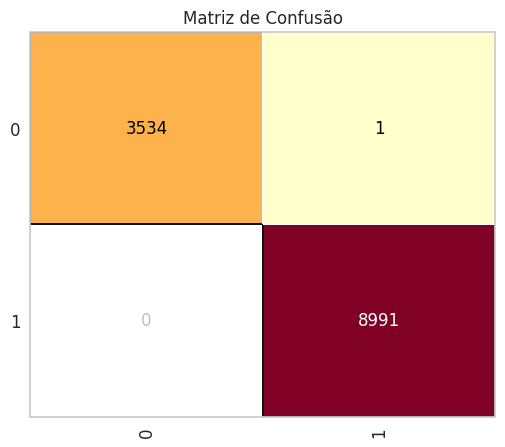

In [111]:
plt.figure(figsize=(6,5))

cm = ConfusionMatrix(random_f)
cm.fit(X_train,Y_train)
cm.score(X_validation, Y_validation)
plt.title('Matriz de Confusão')

plt.show()